In [ ]:
import json, logging
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import make_scorer
from pathlib import Path
from datetime import datetime
from scipy.stats import skew, kurtosis

In [ ]:
NOTEBOOK_NAME = "BIGMIX-XGBoost-Default"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="xgb_runtime_model"):
    model_path = RUN_DIR / "model" / f"{name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")


def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")


def save_metrics(name: str, value):
    with open(RUN_DIR / "metrics" / f"{name}.json", "w") as f:
        json.dump(value, f, indent=2)

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [3]:
df_features = pd.read_csv('data/BIGMIX-train_test-features-withfilename.csv')
df_cplex_runtimes = pd.read_csv('data/BIGMIX-cplex.csv', header=None, names=["INSTANCE_ID","runtime"])
df_cplex_runtimes["runtime"] = pd.to_numeric(df_cplex_runtimes["runtime"])
df_features.head()

,INSTANCE_ID,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,23305.0,12498.0,169861.0,0.0,0.0,0.0,0.003246,0.032012,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.51667
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,1693.0,1628.0,12084.0,0.0,0.0,0.0,0.029611,0.096698,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.38333
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,3815.0,2676.0,15667.0,0.0,0.0,0.0,0.088451,1.245560,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.38333
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,15864.0,6844.0,53808.0,0.0,0.0,0.0,0.000003,0.000162,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.56667
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,838.0,1337.0,3418.0,0.0,0.0,0.0,0.398217,0.413461,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.36667


In [4]:
df_cplex_runtimes.head()

,INSTANCE_ID,runtime
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,35.56
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,3600.01
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,105.12
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,4.78
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,46.91


In [5]:
# Steps from Hutter et al.(compare preeliminaries):
# 1. Remove constant columns
# 2. Replace the sentinel –512 with NaN
# 3. Standardise every remaining column to mean 0 / std 1. The means/SDs are computed ignoring NaNs.
# 4. Fill the remaining NaNs with 0, so a “missing” value is interpreted as “the mean of that column” after scaling.


# instance id does nothing for performance prediction
df_features.drop(['INSTANCE_ID'], inplace=True, axis=1)
df_cplex_runtimes.drop(['INSTANCE_ID'], inplace=True, axis=1)
# Some rows have the same values - we won't be needing them as they only increase complexity.
single_value_cols = df_features.columns[df_features.nunique(dropna=False) == 1]
single_value_cols

Index([' probtype', ' nq_vars', ' nq_constr', ' nq_nzcnt', ' num_s_variables',
       ' num_n_variables', ' ratio_s_variables', ' ratio_n_variables',
       ' itcnt_max', ' numnewsolution_sum', ' newin_sum', ' nodeleft_avg',
       ' nodeleft_varcoef', ' diffObj_avg', ' diffObj_median',
       ' diffObj_varcoef', ' diffObj_q90mq10', ' numfeas', ' iinf_avg',
       ' iinf_median', ' iinf_varcoef', ' iinf_q90mq10', ' diffBestInt_avg',
       ' diffBestInt_median', ' diffBestInt_varcoef', ' diffBestInt_q90mq10',
       ' diffBestObjUp_avg', ' diffBestObjUp_median', ' diffBestObjUp_varcoef',
       ' diffBestObjUp_q90mq10', ' numcuts_sum', ' diffGap_avg',
       ' diffGap_median', ' diffGap_varcoef', ' diffGap_q90mq10'],
      dtype='object')

In [6]:
df_features.drop(single_value_cols, axis=1, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [7]:
df_features.dtypes

n_vars             float64
n_constr           float64
n_nzcnt            float64
lp_avg             float64
lp_l2_avg          float64
                    ...   
time_relax         float64
time_VCG0          float64
time_VCG1          float64
time_VCG2          float64
cplex_prob_time    float64
Length: 113, dtype: object

In [8]:
df_features.replace(-512, np.nan, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [9]:
stats = pd.DataFrame({
    'mean':        df_features.mean(),
    'std':         df_features.std(),
    'range':       df_features.max() - df_features.min(),
    'IQR':         df_features.quantile(0.75) - df_features.quantile(0.25),
    'CV':          df_features.std() / df_features.mean().abs().replace(0, np.nan),
    'skewness':    df_features.apply(skew, nan_policy='omit'),
    'kurtosis':    df_features.apply(lambda x: kurtosis(x, nan_policy='omit')),
    'outlier_%':   df_features.apply(lambda x: ((x < x.mean() - 3*x.std()) | (x > x.mean() + 3*x.std())).mean() * 100)
})

# sorting by biggest disparities.
stats_sorted = stats.sort_values(by='std', ascending=False)
print(stats_sorted)

                                    mean           std         range  \
rhs_c_1_varcoef             8.232340e+12  1.201055e+14  2.198990e+15   
vcg_constr_weight0_varcoef  1.573769e+09  4.371219e+10  1.366271e+12   
rhs_c_0_varcoef             7.790292e+08  2.181342e+10  7.419560e+11   
lp_objval                   6.796390e+08  1.848195e+10  5.505064e+11   
vcg_var_weight1_varcoef     8.308102e+08  1.359669e+10  3.866540e+11   
...                                  ...           ...           ...   
ratio_i_variables           6.284712e-02  2.021037e-01  1.000000e+00   
time_VCG0                   4.835541e-02  1.710137e-01  3.016670e+00   
a_normalized_varcoefs1_avg  6.486363e-02  1.669082e-01  1.756240e+00   
ratio_unbounded_disc        2.790155e-02  1.644828e-01  1.000000e+00   
time_VCG1                   1.885211e-02  1.028872e-01  1.966670e+00   

                                     IQR         CV   skewness     kurtosis  \
rhs_c_1_varcoef                 4.560070  14.589477  16.

In [10]:
X = df_features.values
runtimes = df_cplex_runtimes['runtime'].clip(lower=0.005).values
y = np.log10(runtimes)

In [11]:
N_FOLDS   = 10
RANDOM_STATE    = 1234
N_BOOST_ROUNDS = 1_000
EARLY_STOP = 50
VERBOSE_EVAL = True


xgb_params = dict(
    objective      = "reg:squarederror",
    tree_method    = "hist",
    eval_metric    = "rmse",
    random_state   = 1234
)

In [12]:
rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=False
    )

def corr_coeff(y_true, mu):
    """
    Pearson correlation between target and predicted mean.
    Equals Matlab’s ‘cc’.
    """
    return np.corrcoef(y_true, mu)[0, 1]

In [13]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": RANDOM_STATE,
}


def corr_coeff(y_true, y_pred):
    """Pearson correlation coefficient."""
    return np.corrcoef(y_true, y_pred)[0, 1]


kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
rmses = []
ccs = []

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    dtrain = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
    dtest = xgb.DMatrix(X[te_idx], label=y[te_idx])

    # Train
    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=N_BOOST_ROUNDS,
        evals=[(dtrain, "train"), (dtest, "valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=VERBOSE_EVAL,
    )

    # Predict and collect metrics
    preds = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
    rmse = np.sqrt(mean_squared_error(y[te_idx], preds))
    cc = corr_coeff(y[te_idx], preds)

    rmses.append(rmse)
    ccs.append(cc)


print("\n" + "=" * 46)
print(f"{N_FOLDS}-fold RMSE: {np.mean(rmses):.3f} ± {np.std(rmses):.3f}")
print(f"{N_FOLDS}-fold  CC:  {np.mean(ccs):.3f} ± {np.std(ccs):.3f}")


[0]	train-rmse:1.17952	valid-rmse:1.23954
[1]	train-rmse:0.93149	valid-rmse:1.00920
[2]	train-rmse:0.75968	valid-rmse:0.87846
[3]	train-rmse:0.64148	valid-rmse:0.79006
[4]	train-rmse:0.55514	valid-rmse:0.74575
[5]	train-rmse:0.49807	valid-rmse:0.69294
[6]	train-rmse:0.45070	valid-rmse:0.67397
[7]	train-rmse:0.40841	valid-rmse:0.65196
[8]	train-rmse:0.37759	valid-rmse:0.63770
[9]	train-rmse:0.34366	valid-rmse:0.62793
[10]	train-rmse:0.32000	valid-rmse:0.63361
[11]	train-rmse:0.30049	valid-rmse:0.62403
[12]	train-rmse:0.29364	valid-rmse:0.62118
[13]	train-rmse:0.27744	valid-rmse:0.61518
[14]	train-rmse:0.27303	valid-rmse:0.61368
[15]	train-rmse:0.26173	valid-rmse:0.60655
[16]	train-rmse:0.25754	valid-rmse:0.60494
[17]	train-rmse:0.25134	valid-rmse:0.60270
[18]	train-rmse:0.24489	valid-rmse:0.60294
[19]	train-rmse:0.23959	valid-rmse:0.60357
[20]	train-rmse:0.23075	valid-rmse:0.60235
[21]	train-rmse:0.22588	valid-rmse:0.59933
[22]	train-rmse:0.21494	valid-rmse:0.59983
[23]	train-rmse:0.207

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import xgboost as xgb


def plot_runtime_scatter_xgb(params_dict,
                             X, y_log10,
                             n_folds=10,
                             lower=1e-4, upper=1e4,
                             figsize=(6, 6), random_state=1234):
    """
    Cross‑validated true vs. predicted runtime scatter for *any* XGBoost
    parameter set.  If 'num_boost_round' is absent, it falls back to 1000.

    Parameters
    ----------
    params_dict : dict
        XGBoost parameters; may or may not include 'num_boost_round'.
    X, y_log10  : array‑like
        Features and target in log‑10 seconds.
    """

    # -------------------------- 1. settings -------------------------------
    params     = params_dict.copy()             # do not mutate caller
    num_round  = params.pop("num_boost_round", 1000)

    kf         = KFold(n_splits=n_folds, shuffle=True,
                       random_state=random_state)
    y_pred_log = np.empty_like(y_log10, dtype=float)

    X_np = np.asarray(X)
    y_np = np.asarray(y_log10)

    # -------------------------- 2. CV loop --------------------------------
    for tr_idx, te_idx in kf.split(X_np):
        dtrain  = xgb.DMatrix(X_np[tr_idx], label=y_np[tr_idx])
        booster = xgb.train(params, dtrain,
                            num_boost_round=num_round,
                            verbose_eval=False)

        dtest   = xgb.DMatrix(X_np[te_idx])
        y_pred_log[te_idx] = booster.predict(dtest)

    # -------------------------- 3. seconds & masks ------------------------
    y_true_sec = 10 ** y_np
    y_pred_sec = 10 ** y_pred_log

    inside  = (y_pred_sec >= lower) & (y_pred_sec <= upper)
    outside = ~inside

    # -------------------------- 4. plotting -------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.set_prop_cycle(None)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(y_true_sec[inside],  y_pred_sec[inside],
               s=18, alpha=0.6, edgecolor="k")
    ax.scatter(y_true_sec[outside],
               np.clip(y_pred_sec[outside], lower, upper),
               s=18, alpha=0.6, edgecolor="k", marker="x", color="tab:blue")

    ax.plot([lower, upper], [lower, upper],
            linestyle="--", linewidth=1.0, color="red")

    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls)
    ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(f"XGBoost (No hyp.)")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    return fig, ax

/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_35561/390126604.py:60: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(y_true_sec[outside],


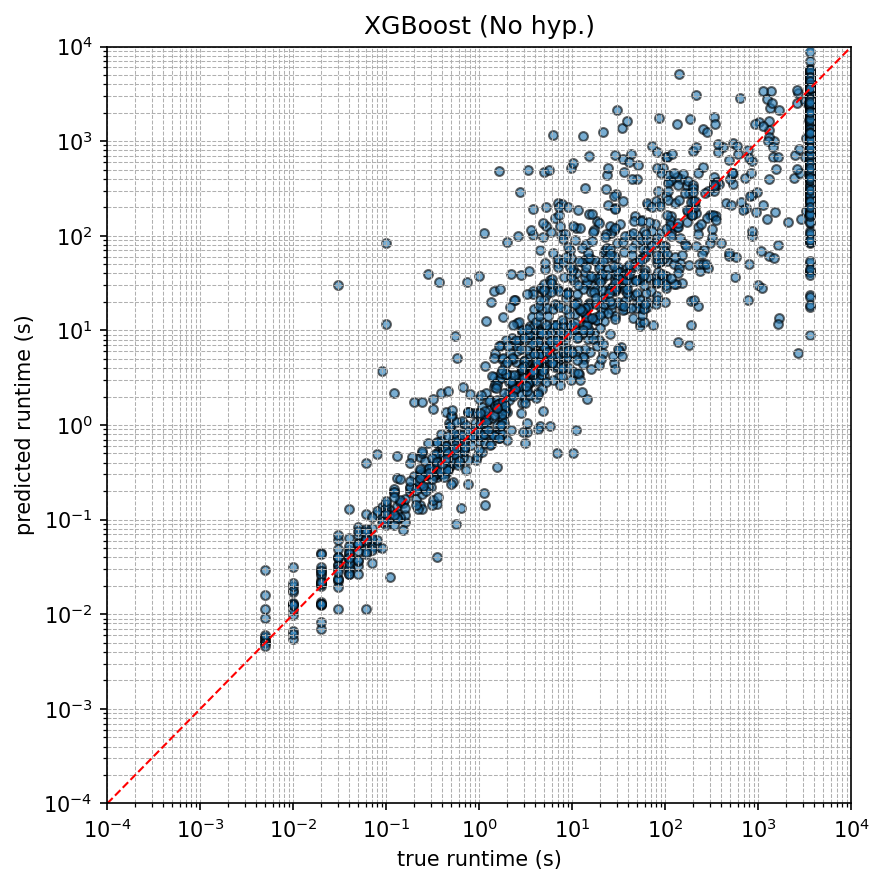

In [22]:
fig, ax = plot_runtime_scatter_xgb(xgb_params, X, y, n_folds=10)
plt.show()

In [ ]:
import xgboost as xgb

feature_names = list(df_features.columns)
dtrain_full = xgb.DMatrix(X, label=y, feature_names=feature_names)

cv_res = xgb.cv(
    params=xgb_params,
    dtrain=dtrain_full,
    num_boost_round=N_BOOST_ROUNDS,
    nfold=N_FOLDS,
    early_stopping_rounds=EARLY_STOP,
    metrics="rmse",
    seed=RANDOM_STATE,
    verbose_eval=False,
)

best_num_boost_round = len(cv_res)
best_row = cv_res.iloc[-1]
save_metrics("xgb_cv", {
    "best_num_boost_round": int(best_num_boost_round),
    "test_rmse_mean": float(best_row["test-rmse-mean"]),
    "test_rmse_std":  float(best_row["test-rmse-std"]),
    "train_rmse_mean": float(best_row["train-rmse-mean"]),
    "train_rmse_std":  float(best_row["train-rmse-std"]),
})

final_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain_full,
    num_boost_round=best_num_boost_round,
    verbose_eval=False,
)

save_model(final_model, name="xgb-runtime-final")